# Stripping Column Anomaly Detection Autoencoder

El Stripping consiste en un proceso físico de separación, en donde uno o más componentes son removidos de un flujo, líquido o gaseoso, mediante la inyección de otro fluido, usualmente a contraflujo.

En esta tarea trabajarán sobre el caso de estudio de una columna de Stripping de una planta de extracción de gas natural, la cual está diseñada para remover, mediante la inyección de Amina, el exceso de CO2 en el gas natural. Lo particular de este sistema es que, cuando los sensores detectan un incremento en la concentración de CO2 por sobre el umbral nominal, se activa una alarma para indicar que la instalación presenta un funcionamiento anómalo.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_04/bin/anomalies_plot.png" height="400">

Así, el propósito de esta tarea es desarrollar un detector de anomalías en el funcionamiento de la columna de Stripping, mediante autoencoders. Similar al caso estudiado con los datos de CMAPSS, en el dataset `stripper_dataset.npz` cuentan con el registro temporal de `10 sensores`, organizados en ventanas temporales de `18 timesteps`, i.e el dataset es de la forma `(n_samples, n_timesteps, n_features)`. La tasa de muestreo del dataset es de `20min` por lo que cada ventana comprende un periodo de `6hrs` de registro.

Adicionalmente, los conjuntos han sido previamente normalizados y separados en conjuntos de entrenamiento, validación, y testing `(X_train, X_val, X_test)`. Cada uno de estos conjuntos, por supuesto, cuentan con sus etiquetas `(Y_train, Y_val, Y_test)` las cuales contienen el estado de alarma de la columna de Stripping `2hrs` después de su ventana correspondiente, donde `1` indica estado de alarma, mientras que `0` indica un funcionamiento nominal en la planta.

El dataset `stripper_dataset.npz` se encontrará disponible en el material docente del curso.

## Formato de Entrega

Los entregables de esta tarea son los siguientes.
- Jupyter Notebook (.ipynb): Todo el procesamiento de la tarea debe estar contenido en un único Notebook. Considere este archivo como un informe de metodología donde se reporten todos los pasos y bloques de código utilizados para resolver el problema. **Sea ordenado**; utilice comentarios en su código y bloques de texto para mejorar la legibilidad del Notebook.

- Reporte Resultados (.pdf): Este archivo debe contener los resultados obtenidos en su tarea, junto con un análisis correspondiente. Considere este documento como la sección de Resultados y Análisis de la tarea. En este sentido, debe mantener un formato de informe estándar.

## 1. Anomaly Detection

Mediante `keras` implementen un `Vanilla Autoencoder` y entrénelo sobre las ventanas temporales `nominales` del conjunto de entrenamiento y validación `(X_train, X_val)`. El objetivo de esto es posteriormente utilizar el error de reconstrucción del `Autoencoder` como un discriminador de anomalías.

Al evaluar su modelo sobre los datos de testing `(X_test)`, deberán definir un umbral de discrimación o `threshold` que, a partir del error de recontrucción de las ventanas temporales, segementará los datos anómalos de los nominales. De este modo, podrán realizar una clasificación binaria de los datos para generar las etiquetas `Y_pred`, que compararán con las etiquetas originales `Y_test`.

El detector de anomalías debe priorizar la disminución de `falsos negativos`, es decir, cuando la planta presenta un estado anómalo en funcionamiento, pero el detector lo clasifica como nominal. En este sentido, no debe presentar más de `30 FN` en el conjunto de testing. Una vez hayan configurado su detector de anomalías, reporten:

- Gráfico de función de pérdida durante el entrenamiento del `Autoencoder`. Una opción es utilizar como set de validación datos que presenten un estado de alarma, para así observar directamente la divergencia en el error de reconstrucción entre ambos conjuntos. Puede utilizar la función `plot_loss_function` presente en el GitHub del curso.
- Gráfico que muestre la discriminación entre datos `nominales` y `anómalos` en función del umbral de su detector de anomalías. Pueden usar el gráfico de este enunciado como referencia.
- Matriz de confusión que compare la clasificación de su detector de anomalías `(Y_pred)` con las etiquetas originales del conjuntos de testing `(Y_test)`. Puede utilizar la función `plot_confusion_matrix` presente en el GitHub del curso.
- Gráfico ROC de la clasificación de su detector de anomalías sobre el conjunto de testing. Recuerden que mientras mayor sea la `AUC` (Area Under Curve) mejor será su discriminador de anomalías.

## Desarrollo

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [25]:
data = np.load('/content/drive/MyDrive/stripper_dataset.npz')
for k in data.keys():
    print(k, data[k].shape)

x_train (4256, 18, 10)
y_train (4256, 1)
x_valid (752, 18, 10)
y_valid (752, 1)
x_test (884, 18, 10)
y_test (884, 1)


In [37]:
def processData(dataset):

    # sacar conjunto X_train
    print('cargar datos')
    X_train = dataset['x_train']
    Y_train = dataset['y_train']
    X_val = dataset['x_valid']
    Y_val = dataset['y_valid']
    X_test = dataset['x_test']
    Y_test = dataset['y_test']


    print(X_train.shape)
    
    # se stackean las simulaciones de entrenamiento
    print('stackear datos')
    X_train_ = X_train
    X_val_ = X_val
    X_test_ = X_test

    n_features = X_train_.shape[2]
    mantener = []

    print('sacar datos constantes')
    for col in range(n_features):
        try:
            std = np.std(X_train_[:,:,col].reshape(-1,1))
            if std > 1e-5:
                mantener.append(col)
        except:
            print('a sacar col ', col)

    mantener = np.array(mantener)
    print('se mantienen los siguientes features ', mantener)

    print(X_train_.shape)

    X_train_ = np.stack([x[:,mantener] for x in X_train_ ])
    X_test_ = np.stack([x[:,mantener] for x in X_test_ ])

    print(X_train_.shape)
    n_features = X_train_.shape[2]

    print('explorar distribuciones de datos de entrenamiento')
    fig, axs = plt.subplots(2, n_features, figsize=(28,4),
                            constrained_layout=True)

    fig.suptitle('sensors histogram', fontsize=24)
    for sensor in range(n_features):
        axs[0,sensor].hist(X_train_[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
        axs[0,sensor].set_title(sensor)
        axs[1,sensor].hist(X_test_[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
    
    plt.show()

    print('reescalando datos con minMaxScaler')

    X_train_ = X_train_.reshape(-1, n_features)
    X_test_ = X_test_.reshape(-1, n_features)
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_train = scaler.fit_transform(X_train_).reshape(-1,18, n_features)
    X_test = scaler.transform(X_test_).reshape(-1,18, n_features)

    print('plotear una simulacion train')
    n = 28
    fig, axs = plt.subplots(1,2,figsize=(20,5))

    axs[0].set_title('RUL {}'.format(Y_train[n]))
    axs[0].set_ylabel('sensors')
    axs[0].set_xlabel('timesteps')
    axs[0].plot(X_train[n])
    axs[1].set_title('RUL {}'.format(Y_test[n]))
    axs[1].set_ylabel('sensors')
    axs[1].set_xlabel('timesteps')
    axs[1].plot(X_test[n])
    plt.show()

    print('explorar distribuciones de datos de entrenamiento y test')
    fig, axs = plt.subplots(2, n_features, figsize=(28,4),
                            sharex='col', sharey='col',
                            constrained_layout=True)

    fig.suptitle('sensors histogram', fontsize=24)
    for sensor in range(n_features):
        axs[0,sensor].hist(X_train[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
        axs[0,sensor].set_title(sensor)
        axs[1,sensor].hist(X_test[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
    
    plt.show()



    return X_train, Y_train, X_test, Y_test

cargar datos
(4256, 18, 10)
stackear datos
sacar datos constantes
se mantienen los siguientes features  [0 1 2 3 4 5 6 7 8 9]
(4256, 18, 10)
(4256, 18, 10)
explorar distribuciones de datos de entrenamiento


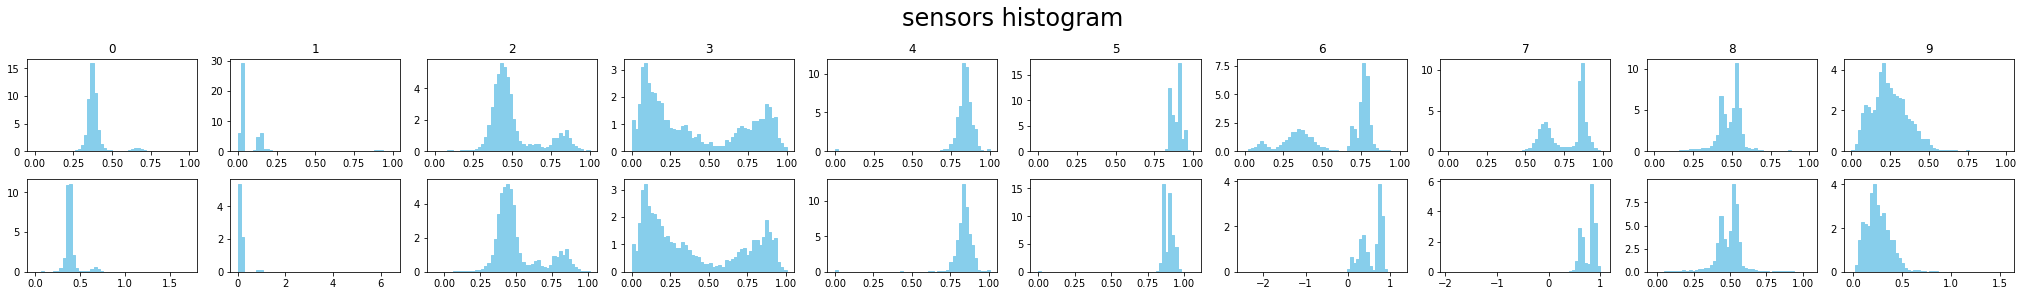

reescalando datos con minMaxScaler
plotear una simulacion train


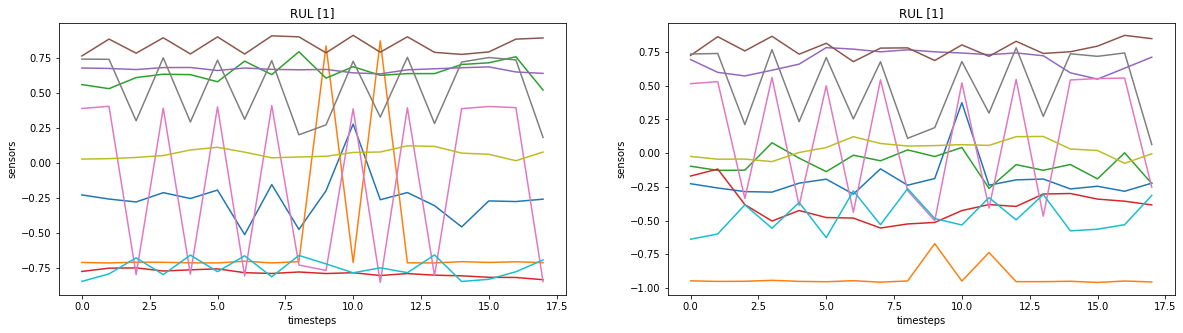

explorar distribuciones de datos de entrenamiento y test


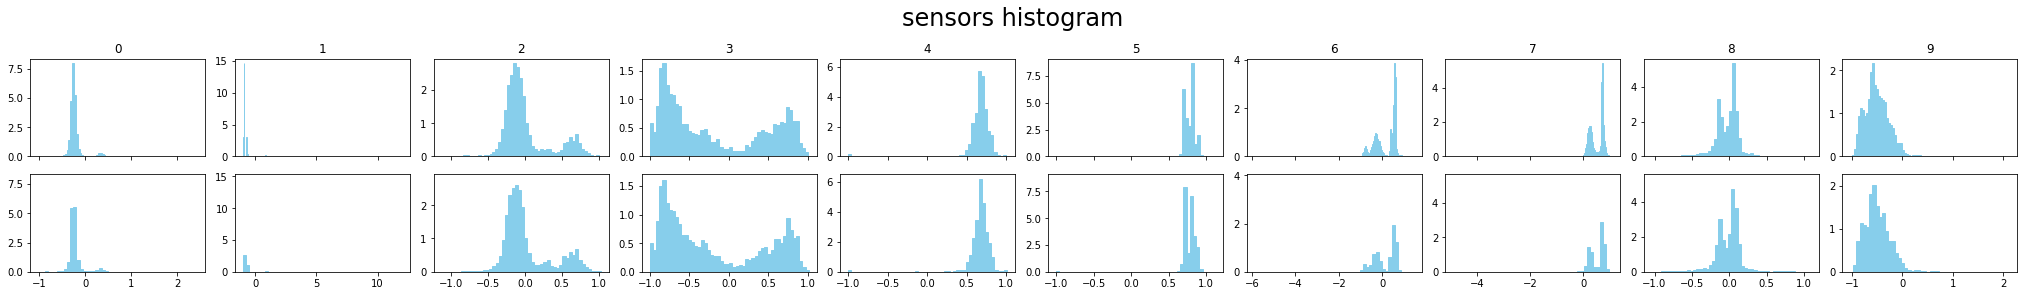

In [38]:
X_train, Y_train, X_test, Y_test = processData(data)